In [4]:
import pandas as pd

# Load the Excel file
xls = pd.ExcelFile('online_retail_II.xlsx')

# View available sheet names
print("Available sheets:", xls.sheet_names)

# Load both sheets into DataFrames
df1 = pd.read_excel(xls, sheet_name='Year 2009-2010')
df2 = pd.read_excel(xls, sheet_name='Year 2010-2011')

# Combine both sheets into a single DataFrame
df = pd.concat([df1, df2], ignore_index=True)

# View the first few rows
df.head()


Available sheets: ['Year 2009-2010', 'Year 2010-2011']


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
# Drop rows where CustomerID is missing
df = df.dropna(subset=['Customer ID'])

# Convert InvoiceNo to string and remove cancelled invoices (those starting with 'C')
df['Invoice'] = df['Invoice'].astype(str)
df = df[~df['Invoice'].str.startswith('C')]

# Remove negative or zero Quantity and UnitPrice
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['Price']

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Reset index after cleaning
df = df.reset_index(drop=True)

# Show cleaned data
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [6]:
# Set reference date for Recency calculation (1 day after the latest invoice)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by Customer ID
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                      # Frequency
    'TotalPrice': 'sum'                                        # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Display first few RFM scores
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,12,77556.46
1,12347.0,2,8,5633.32
2,12348.0,75,5,2019.40
3,12349.0,19,4,4428.69
4,12350.0,310,1,334.40


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and target
X = rfm[['Recency', 'Frequency']]
y = rfm['Monetary']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"📉 RMSE: {rmse:.2f}")
print(f"📈 R^2 Score: {r2:.2f}")


📉 RMSE: 14829.46
📈 R^2 Score: 0.40


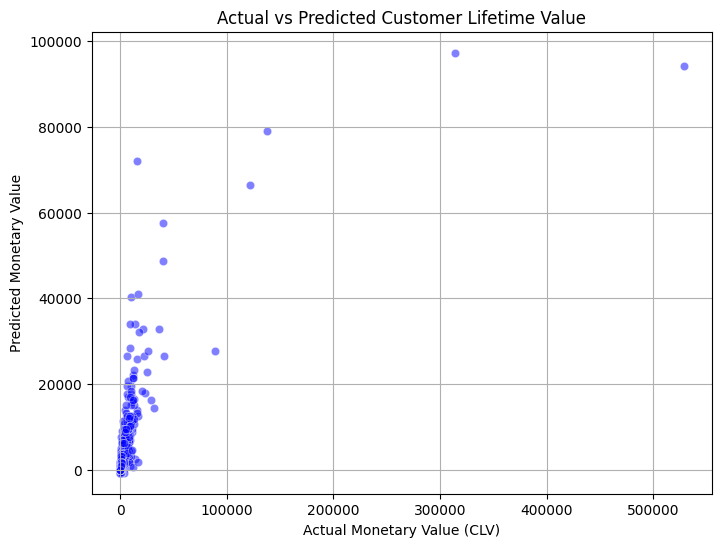

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='blue')
plt.xlabel("Actual Monetary Value (CLV)")
plt.ylabel("Predicted Monetary Value")
plt.title("Actual vs Predicted Customer Lifetime Value")
plt.grid(True)
plt.show()


In [10]:
# Define Customer class
class Customer:
    def __init__(self, customer_id, recency, frequency, monetary):
        self.customer_id = customer_id
        self.recency = recency
        self.frequency = frequency
        self.monetary = monetary

    def summary(self):
        return f"Customer {self.customer_id} -> R: {self.recency}, F: {self.frequency}, M: {self.monetary}"

# Example usage
example = rfm.iloc[0]
c1 = Customer(example['CustomerID'], example['Recency'], example['Frequency'], example['Monetary'])
print(c1.summary())


Customer 12346.0 -> R: 326.0, F: 12.0, M: 77556.46


In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# View cluster sizes
rfm['Cluster'].value_counts()


Cluster
1    3841
0    1998
2      35
3       4
Name: count, dtype: int64

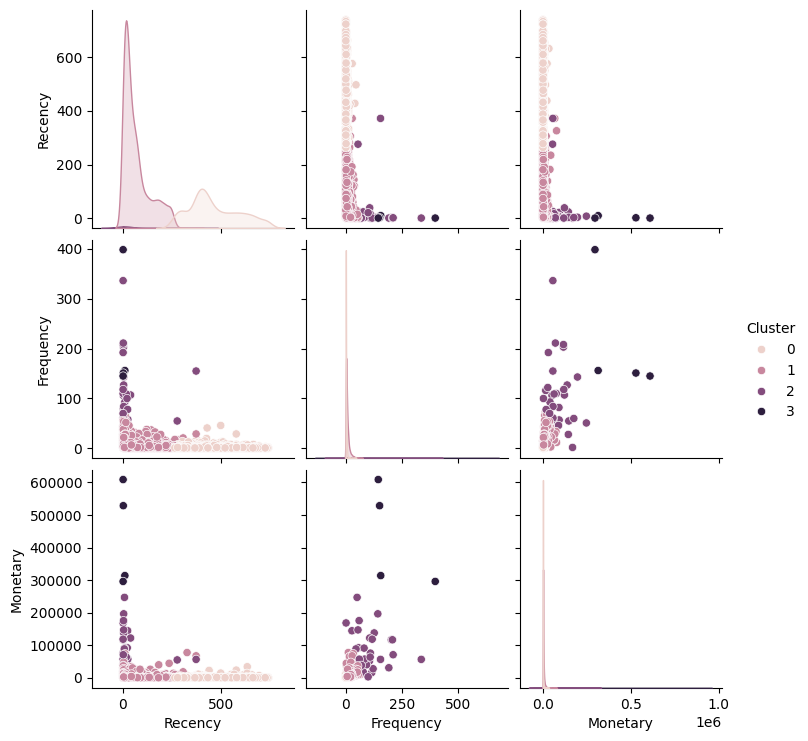

In [12]:
import seaborn as sns
sns.pairplot(rfm, hue="Cluster", vars=['Recency', 'Frequency', 'Monetary'])


In [13]:
!pip install -q pandasql
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

# Example SQL query
query = """
SELECT CustomerID, Recency, Frequency, Monetary
FROM rfm
WHERE Monetary > 1000
ORDER BY Frequency DESC
LIMIT 5
"""
pysqldf(query)



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


,CustomerID,Recency,Frequency,Monetary
0,14911.0,1,398,295972.63
1,12748.0,1,336,56599.39
2,17841.0,2,211,70884.07
3,15311.0,1,208,116771.16
4,13089.0,3,203,116737.86


In [14]:
# Simulated GenAI insights based on customer type
def genai_summary(row):
    if row['Recency'] > 120 and row['Frequency'] < 2:
        return "⚠️ Inactive customer. Consider re-engagement."
    elif row['Monetary'] > 1000:
        return "💎 High-value customer. Offer loyalty perks."
    elif row['Frequency'] > 10:
        return "🔁 Loyal customer. Send personalized offers."
    else:
        return "🙂 Regular customer."

# Apply GenAI logic
rfm['GenAI_Insight'] = rfm.apply(genai_summary, axis=1)

# View a few examples
rfm[['CustomerID', 'GenAI_Insight']].head()


,CustomerID,GenAI_Insight
0,12346.0,💎 High-value customer. Offer loyalty perks.
1,12347.0,💎 High-value customer. Offer loyalty perks.
2,12348.0,💎 High-value customer. Offer loyalty perks.
3,12349.0,💎 High-value customer. Offer loyalty perks.
4,12350.0,⚠️ Inactive customer. Consider re-engagement.


In [15]:
rfm.to_csv("Final_CLV_Segments.csv", index=False)
